In [17]:
# 한글처리
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (14.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and direc

In [1]:
# 필수 라이브러리
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install mglearn
import mglearn

# 음수표현 라이브러리
plt.rcParams['axes.unicode_minus'] = False

# 경고무시
import warnings
warnings.filterwarnings("ignore")

# 매직명령어 : 시각화 결과가 노트북에 포함되도록
%matplotlib inline

# 폰트설정
plt.rc('font', family='NanumGothic')

# Bike Sharing Demand

- 데이터셋: 'bike_train.csv'
- 알고리즘: 회귀
- 평가지표: RMSLE(캐글에서 요구한 성능 평가 방법, Root Mean Squared Log Error)
- RMSLE의 장점
  - 아웃라이어가 있더라도 크게 영향을 받지 않는다.
  - 상대적 Error를 측정
  - Under Estimation에 큰 페널티를 부여
  - 사이킷런에서는 RMSLE를 제공하지 않아 직접 함수를 만들어서 구현해야 한다.

# Dataset Loading

In [3]:
bike_df = pd.read_csv('bike_train.csv')
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


**Dataset Features**
- datetime: 날짜
- season: 1-봄, 2-여름, 3-가을, 4-겨울
- holiday: 0-평일, 1-주말 및 휴일
- workingday: 0-주말 및 휴일, 1-주중
- weather: 1-맑음 및 약간 흐림, 2-안개 및 안개+흐림, 3-가벼운 눈/비/천둥, 4-심한 눈/비/천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대 습도
- windspeed: 풍속
- casual: 미등록 사용자 대여수
- registered: 등록된 사용자 대여수
- count: 대여 횟수(casual + registered)

# Preprocessing

In [5]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [6]:
# datetime, casual, registered 컬럼 삭제
bike_df.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)

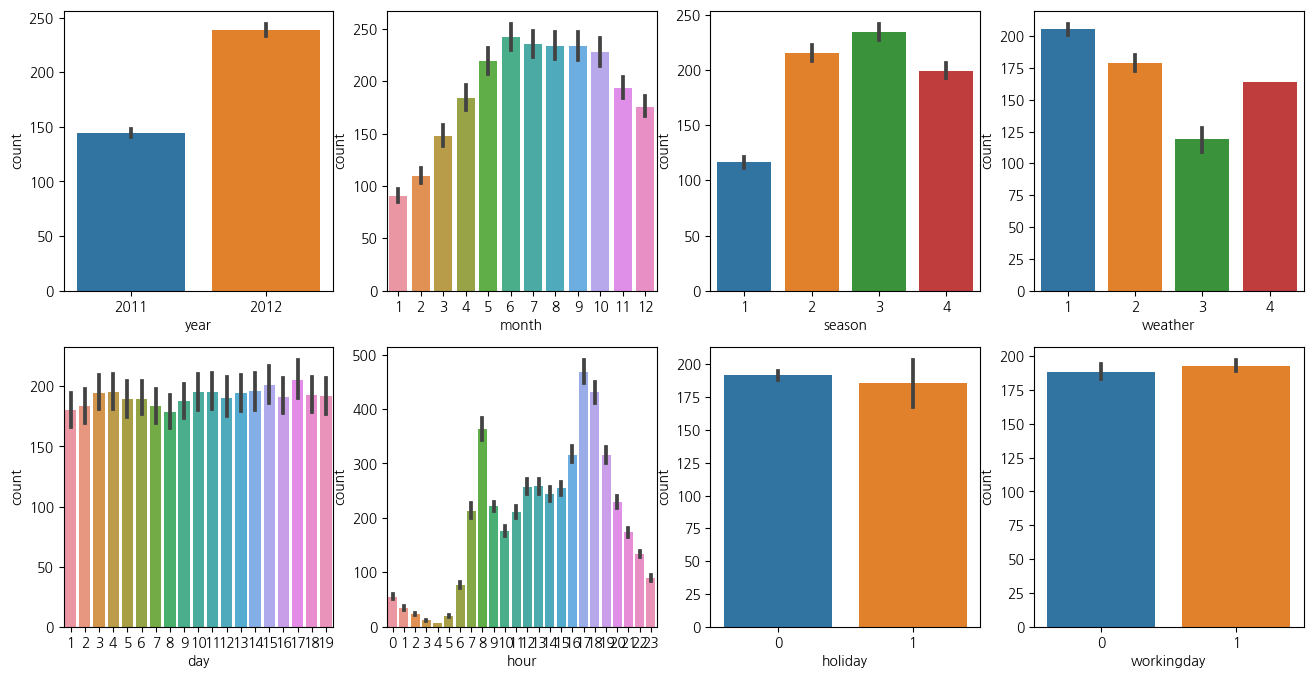

In [7]:
# target 분포 시각화
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
# cat_features에 있는 모든 컬럼별로 개별 컬럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4
  # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
  import seaborn as sns
  sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

- year: 2011년에 비해 2012년이 훨씬 더 높은 것으로 보아 자전거 대여 수가 갈수록 증가하는 추세
- month: 1,2,3월이 낮고 6,7,8,9월이 높음
- season: 봄, 겨울이 낮고 여름, 가을이 높음
- weather: 눈이나 비오는 날이 낮고 맑거나 약간 안개가 있는 날씨가 높음
- hour: 출퇴근시간이 상대적으로 높음
- holiday, workingday: 주중이 상대적으로 약간 높음

# 평가지표(RMSLE)

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환시 NaN등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
## log1p = 1+log
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

## train / test

In [24]:
from sklearn.model_selection import train_test_split
y_target = bike_df['count']
x_features = bike_df.drop(['count'], axis=1, inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=0)

# Modeling
- 회귀 모델

## LinearRegression

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

lir = LinearRegression()
lir.fit(x_train, y_train)
pred = lir.predict(x_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


**비교적 큰 예측 오류**

In [26]:
# 실제값과 예측값의 차이 정도
def get_top_error(y_test, pred, n_tops=5):
  # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

  # 예측값과 실제값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


**예측 오류가 클 때**
1. Target 값의 분포가 왜곡된 형태인지 확인
  - 정규분포 형태가 가장 좋다.

<Axes: >

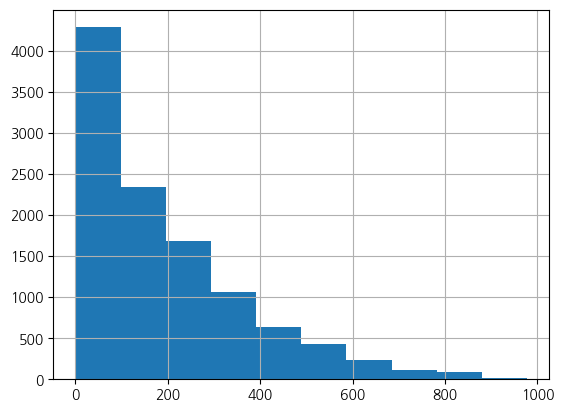

In [27]:
y_target.hist()

**정규분포가 아닌 0~200사이에 왜곡돼 있다.**
- np.log1p()를 이용해 정규분포형태로 바꾸기
- 변경된 타겟값을 기반으로 학습하고 예측한 값은 다시 expm1()함수를 통해 원래 scale 값으로 원상복구

<Axes: >

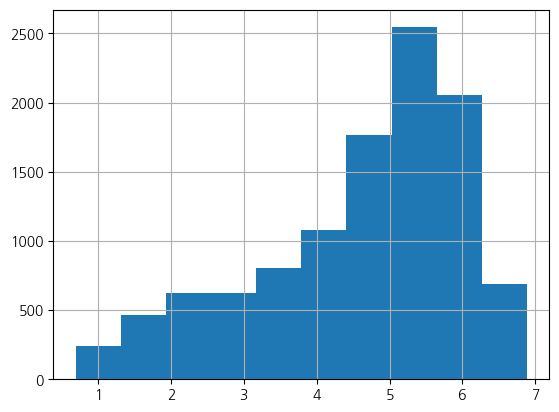

In [28]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

**정규분포 형태는 아니지만 왜곡이 많이 나아졌다.**

In [29]:
# 타겟컬럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 train/test 분할
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target_log,
                                                    test_size=0.3, random_state=0)

lir = LinearRegression()
lir.fit(x_train, y_train)
pred = lir.predict(x_test)

# 테스트 셋의 타겟값은 로그 변환됐으므로 다시 expm1을 통해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습되어 예측했으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<Axes: >

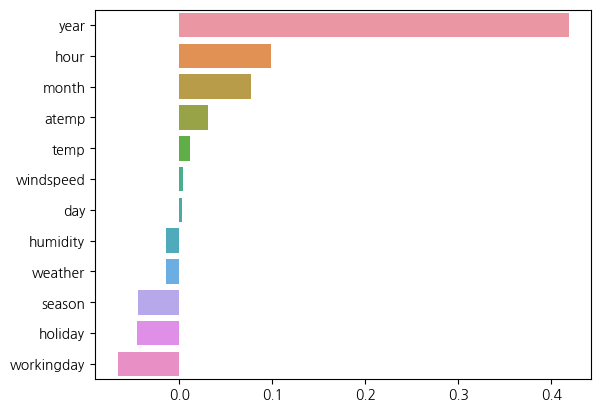

In [30]:
# 각 피처의 회귀 계숫값 시각화
coef = pd.Series(lir.coef_, index=x_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높다.
- year, hour, month 등이 가지고 있는 숫자 값은 카테고리형이지만 회귀 계수 연산 시 숫자 크기에 영향을 받기 때문에 원-핫 인코딩을 적용해 변환 필요

### One-Hot Encoding

In [31]:
# 'year', 'month', 'day', 'hour' 등의 피처들을 One Hot Encoding
x_features_ohe = pd.get_dummies(x_features, columns=['year', 'month', 'day', 'hour',\
                                                     'holiday', 'workingday', 'season','weather'])

In [32]:
# model, train/test dataset => 평가 수치 함수 생성
# 원-핫 인코딩이 적용된 피처데이터셋 기반으로 train/test 분할
x_train, x_test, y_train, y_test = train_test_split(x_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# model, train/test dataset => 평가 수치 함수 생성
def get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1=False):
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별로 평가 수행
lir = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.01)
elasticn = ElasticNet
for model in [lir, ridge, lasso]:
  get_model_predict(model, x_train, x_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


**원-핫 인코딩 후 선형 회귀의 예측 성능 많이 향상됨**

<Axes: >

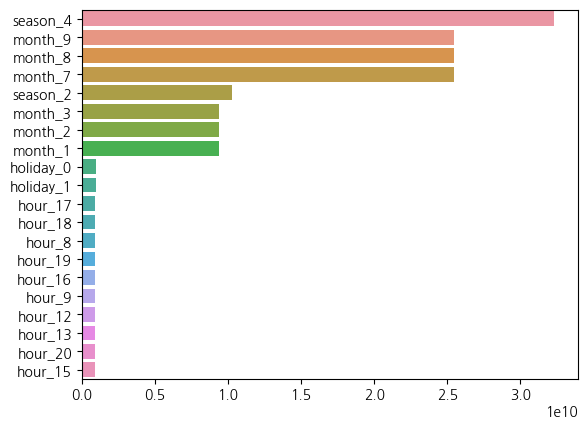

In [42]:
# 회귀 계수가 높은 피처 시각화(상위 20개)
coef = pd.Series(lir.coef_, index=x_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)
coef_sort = coef_sort[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

**원-핫 인코딩을 통해 피처들의 영향도가 달라졌고, 모델의 성농도 향상되었다.**

In [34]:
lir.coef_

array([ 8.48429757e-03,  1.46528651e-02, -3.36511117e-03, -3.72680403e-03,
       -1.49192772e+09, -1.49192772e+09,  9.40692651e+09,  9.40692651e+09,
        9.40692651e+09, -5.25814861e+09, -5.25814861e+09, -5.25814861e+09,
        2.54577786e+10,  2.54577786e+10,  2.54577787e+10, -2.73251632e+10,
       -2.73251632e+10, -2.73251632e+10, -7.78786443e+08, -7.78786443e+08,
       -7.78786443e+08, -7.78786443e+08, -7.78786443e+08, -7.78786443e+08,
       -7.78786443e+08, -7.78786443e+08, -7.78786443e+08, -7.78786443e+08,
       -7.78786443e+08, -7.78786443e+08, -7.78786443e+08, -7.78786443e+08,
       -7.78786443e+08, -7.78786443e+08, -7.78786443e+08, -7.78786443e+08,
       -7.78786443e+08,  9.18892101e+08,  9.18892101e+08,  9.18892100e+08,
        9.18892100e+08,  9.18892099e+08,  9.18892100e+08,  9.18892101e+08,
        9.18892102e+08,  9.18892103e+08,  9.18892103e+08,  9.18892102e+08,
        9.18892103e+08,  9.18892103e+08,  9.18892103e+08,  9.18892103e+08,
        9.18892103e+08,  

## 회귀트리

In [37]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 원-핫 인코딩 된 피처 데이터셋 이용 랜덤 포레스트, GBM, XGBoostm LightGBM model별 평가 수행
rf = RandomForestRegressor(n_estimators=500)
gbm = GradientBoostingRegressor(n_estimators=500)
xgb = XGBRegressor(n_estimators=500)
lgbm = LGBMRegressor(n_estimators=500, force_row_wise=True)

for model in [rf, gbm, xgb, lgbm]:
  # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환
  get_model_predict(model, x_train.values, x_test.values,
                    y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.160, MAE: 31.084
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.339, MAE: 32.741
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


**선형 회귀 모델보다 회귀 트리의 예측 성능이 더 높다.**